# 고양이 수염 스티커 만들기
## 코드

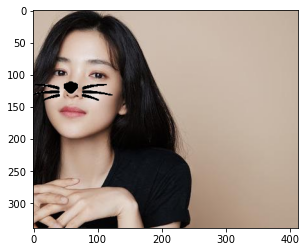

In [1]:
import os
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt


# 1. 얼굴 검출
# 1-1. 이미지 불러오기
img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/tae.jpg'
img_bgr = cv2.imread(img_path)  # 이미지 읽어서 저장
img_show = img_bgr.copy()       # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 1-2. detector를 선언하여 얼굴 영역 좌표 찾기
# 만약 얼굴이 여러개라면 len(dlib_rects) = n
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)  # 찾은 얼굴 영역 좌표

# 1-3. 얼굴의 bounding box 그리기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    # check - face bounding box
    # cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)  # img_show에 라인 그리기


# 2. 얼굴 랜드마크 검출
# 2-1. 저장한 landmark 모델을 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 2-2. 개별 위치에 접근하여 (x,y)형태로 변환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# check - face landmark
# for landmark in list_landmarks:
#     for idx, point in enumerate(list_points):
#         cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow
# plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.show()


# 3. 스티커 적용 위치 확인하기
# 3-1. 코의 좌표 확인 및 스티커의 위치 지정
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # print(landmark[30])  # nose center index (187, 367)
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()

# 3-2. 스티커 이미지 사이즈 수정
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))

# 3-3. 스티커 이미지의 x,y좌표 조정. 이미지의 시작점은 top-left이기때문에.
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top


# 4. 원본이미지에 스티커 적용
# 4-1. 스티커가 이미지를 벗어날 경우 잘라주기
if refined_x + w > img_show.shape[1]:  # 오른쪽으로 벗어날 경우
    img_sticker = img_sticker[:, :img_show.shape[1]-(refined_x+w)]
elif refined_x < 0:                    # 왼쪽으로 벗어날 경우
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

# 4-2. 스티커 이미지 영역 잡아주기
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# 4-3. 스티커를 이미지에 적용하기
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] \
    = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 회고
### 이번 프로젝트에서 **어려웠던 점,**
이미지의 좌표를 이해하는데 오래 걸렸고, 슬라이싱하는데 헷갈려서 테스트하고 확인하는 과정이 꽤 오래 걸렸다.


### 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
얼굴각도, 이미지 밝기, 촬영거리, 화질 등을 변경시킨 다양한 사진을 가지고 해봤는데 스티커는 정상적으로 붙여졌지만,
얼굴 각도가 다른 사진으로 실험하니 `get_frontal_face_detector()`를 통해 생성된 face_detecor객체가 인식하지 못하였다.
이 부분은 어떻게 해결해야할지 좀 더 찾아봐야할 것 같다.


### 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
`get_frontal_face_detector()`의 `upsample_num_times`(정밀한 탐색을 위해 이미지를 확대하는 횟수)의 값을 5까지 늘려봤는데 시간이 30초 정도 지났는데도 불구하고 얼굴영역을 잡아내지 못했다. 10으로 넣었더니 아예 SIGKILL이 됐다.(image -> camera_sticker/images/w6.jpeg)


### 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
우선적으로 해당 이미지가 왜 인식이 되지 못했는지를 판단할 수 있는 지표를 파악해야할 것 같다.


### **자기 다짐**
다양한 변수에도 인식할 수 있는 방법들을 찾아봐야 할 것 같다. 서치하다 팔, 다리도 인식하는 것을 보았는데 한 번 구현해보는 것도 재밌을 것 같고, 사진만이 아니라 실제로 움직이는 피사체를 인식하여 스티커를 적용해보는 것도 재밌을 것 같다. 쓰다 보니 다짐보다 해보고 싶은 것만 적은 것 같다.